본 노트북은 아래의 내용에 대해 기술하며 코드 및 결과물을 보여준다.

- 각 HDD 모델별 Power-On Hours(009), Total LBAs Written(241), Total LBAs Read(242)에 따른 실패율 누적 자료를 만들자.
- 그리고 이를 그래프로 시각화해보자.
- 이전에는 놓친 HDD 시리얼을 고려하여 실패율을 분석해보자.
  - 이전에는 모든 데이터를 몽땅 집어 넣어 분석에 중복이 발생하였다. 한 HDD에 대해 수십, 수백일 동안 측정된 데이터를 모두 개별 HDD에 대한 데이터로 판단했으니 이는 합리적인 분석이 아니다. 게다가 우리가 사용할 SMART 데이터는 누적 데이터를 나나탠다(사용 시간, 읽기 및 쓰기 횟수 등).
  - 따라서 가장 마지막에 수집된 HDD 정보에 대해서만 그 결과를 판단할 것이다.
  - 이때, 2022년도 기준으로 12월 31일까지 정상적으로 구동된 HDD는 정상으로 본다.
  - 중간에 교체됐든 고장났든 간에 12월 31일 이전에 사라졌지만 실패하지 않은 HDD는 정상으로 본다.
  - 다시 말해 마지막으로 수집된 정보에 대해 실패한 HDD만 실패로 보겠다는 의미이다.

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Load Dataset

In [2]:
path = './data/2022/'
path_files = os.listdir(path)
path_files.sort()

print(path_files[0], path_files[-1], len(path_files))

2022-01-01.csv 2022-12-31.csv 365


In [3]:
pd.read_csv('./data/2022/2022-01-01.csv')

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2022-01-01,ZLW18P9K,ST14000NM001G,14000519643136,0,73.0,20467240.0,NaN,NaN,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01,ZLW0EGC7,ST12000NM001G,12000138625024,0,84.0,228715872.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01,ZA1FLE1P,ST8000NM0055,8001563222016,0,82.0,157857120.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01,ZA16NQJR,ST8000NM0055,8001563222016,0,84.0,234265456.0,NaN,NaN,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01,1050A084F97G,TOSHIBA MG07ACA14TA,14000519643136,0,100.0,0.0,100.0,0.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206949,2022-01-01,ZA10MCEQ,ST8000DM002,8001563222016,0,80.0,109616432.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206950,2022-01-01,ZA13ZBCT,ST8000DM002,8001563222016,0,78.0,62303504.0,NaN,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206951,2022-01-01,ZHZ3QPZX,ST12000NM0008,12000138625024,0,77.0,48195944.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206952,2022-01-01,41B0A01LFV8G,TOSHIBA MG08ACA16TEY,16000900661248,0,100.0,0.0,100.0,0.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_pkl_path = './temp/hdd-failure-analysis.pkl'

if os.path.exists(df_pkl_path):
    # load from pickle
    df = pd.read_pickle(df_pkl_path)
    print('cached hdd smart data loaded')
else:
    # create new dataframe
    df = pd.DataFrame()
    print('creating new dataframe')

    for path_file in tqdm(path_files):
        # read csv
        _temp_df = pd.read_csv(path + '/' + path_file)
        # select columns what we need
        _temp_df = _temp_df[[
            'date', 'serial_number', 'model', 'failure',
            'smart_9_raw', 'smart_241_raw', 'smart_242_raw'
        ]]
        # append to df
        df  = pd.concat([df, _temp_df], ignore_index=True)

    # save to pickle
    df.to_pickle(df_pkl_path)

cached hdd smart data loaded


### Get Distinct Model

In [5]:
models = df['model'].unique()
models

array(['ST14000NM001G', 'ST12000NM001G', 'ST8000NM0055',
       'TOSHIBA MG07ACA14TA', 'HGST HMS5C4040BLE640', 'ST8000DM002',
       'ST12000NM0008', 'ST4000DM000', 'HGST HUH721212ALE604',
       'Seagate BarraCuda 120 SSD ZA250CM10003', 'WDC WUH721414ALE6L4',
       'HGST HUH721212ALN604', 'HGST HUH721212ALE600',
       'TOSHIBA MG08ACA16TE', 'HGST HMS5C4040ALE640', 'ST14000NM0138',
       'ST12000NM0007', 'DELLBOSS VD', 'ST16000NM001G',
       'TOSHIBA MG07ACA14TEY', 'WDC WD5000LPVX', 'TOSHIBA MG08ACA16TEY',
       'ST500LM012 HN', 'ST6000DX000', 'ST10000NM0086',
       'WDC WUH721816ALE6L0', 'HGST HDS5C4040ALE630', 'ST18000NM000J',
       'ST8000DM005', 'ST500LM030', 'HGST HUH728080ALE600',
       'TOSHIBA MD04ABA400V', 'TOSHIBA MQ01ABF050', 'Seagate SSD',
       'Seagate BarraCuda SSD ZA250CM10002', 'ST14000NM0018',
       'TOSHIBA MQ01ABF050M', 'ST8000NM000A', 'MTFDDAV240TCB',
       'CT250MX500SSD1', 'ST4000DM005', 'WDC  WUH721414ALE6L4',
       'WDC WDS250G2B0A', 'WDC WD5000LPCX

### Leave recent data

In [6]:
distinct_hdd_df: pd.DataFrame = df.groupby(['model', 'date', 'serial_number']).aggregate({
    'failure': 'sum',
    'smart_9_raw': 'last',
    'smart_241_raw': 'last',
    'smart_242_raw': 'last'
})

In [7]:
# for test
distinct_hdd_df.loc['ST14000NM001G'].dropna()

failure  smart_9_raw  smart_241_raw  smart_242_raw
date       serial_number                                                    
2022-01-01 ZL201VZX             0       9932.0   7.593225e+10   1.421446e+11
           ZL2077KW             0       3938.0   4.482022e+10   5.088528e+10
           ZL2077NC             0       3943.0   4.473024e+10   5.041021e+10
           ZL209CRX             0      11298.0   7.412599e+10   1.493324e+11
           ZL20A2G8             0      11672.0   7.517760e+10   2.085731e+11
...                           ...          ...            ...            ...
2022-12-31 ZTM094RF             0      13125.0   7.768714e+10   1.815542e+11
           ZTM094V6             0      12636.0   7.560856e+10   1.759552e+11
           ZTM0952D             0      13101.0   7.784083e+10   1.802015e+11
           ZTM096B0             0      13116.0   7.825808e+10   1.803176e+11
           ZTM096M0             0      13852.0   9.468262e+10   1.624038e+11

[3901536 rows x 4 columns]

* 누적 히스토그램(cumulative histogram)이란, 일반형 히스토그램(ordinary histogram)에서 얻어진 구간별 빈도수를 이전의 모든 구간들의 값으로 누적시키는 방식으로 얻은 것

In [127]:
def get_failure_rate(model, feature, bin_width, cumulative=True):
    global distinct_hdd_df

    # get model dataframe(without nan)
    model_df = distinct_hdd_df.loc[model].dropna()

    # get bins
    bins = np.arange(model_df[feature].min(), model_df[feature].max() + bin_width, bin_width)

    # get histogram (len(bin_edges) = len(counts) + 1)
    counts, bin_edges = np.histogram(model_df[feature], bins=bins)
    counts_cumsum = np.cumsum(counts)

    # get histogram of failure hdd
    counts_failure, _ = np.histogram(model_df[model_df['failure'] > 0][feature], bins=bins)
    counts_failure_cumsum = np.cumsum(counts_failure)

    # calculate failure rate
    if cumulative:
        failure_rate = counts_failure_cumsum / counts_cumsum
    else:
        failure_rate = counts_failure / counts

    return failure_rate, bin_edges

### Power-On Hour

In [145]:
failure, bin_edges = get_failure_rate('ST12000NM001G', 'smart_9_raw', 100, cumulative=True)

In [146]:
failure

array([0.00000000e+00, 2.23363860e-04, 1.47863374e-04, 1.10265740e-04,
       8.76501008e-05, 7.13877784e-05, 6.10388818e-05, 1.06535983e-04,
       9.45402978e-05, 8.50520944e-05, 1.15420129e-04, 1.05719421e-04,
       9.74943941e-05, 9.04349923e-05, 8.45570619e-05, 7.94281176e-05,
       7.47495889e-05, 7.07163567e-05, 6.69747505e-05, 6.34195840e-05,
       6.03366787e-05, 5.75318823e-05, 5.49631747e-05, 5.25974368e-05,
       5.02925349e-05, 4.81069899e-05, 4.60751640e-05, 4.39611969e-05,
       4.19556948e-05, 4.01133872e-05, 3.84418247e-05, 3.69230769e-05,
       3.53873738e-05, 3.39140167e-05, 3.23669986e-05, 3.09010754e-05,
       2.95776314e-05, 2.83583359e-05, 2.72244657e-05, 2.60217889e-05,
       2.47960525e-05, 2.35952935e-05, 2.23737005e-05, 2.12806708e-05,
       2.02885025e-05, 1.93230492e-05, 1.83858454e-05, 1.74985272e-05,
       1.66848346e-05, 1.58691535e-05, 1.51186055e-05, 1.44266142e-05,
       1.37557258e-05, 1.31326087e-05, 1.25555583e-05, 1.20335978e-05,
      

- 그래프 보는 법
  - 가로 축은 사용 누적 시간
  - 세로 축은 사용 누적 시간에 대한 실패율 (해당 시간 동안 가동된 HDD 중 실패가 일어난 비율)

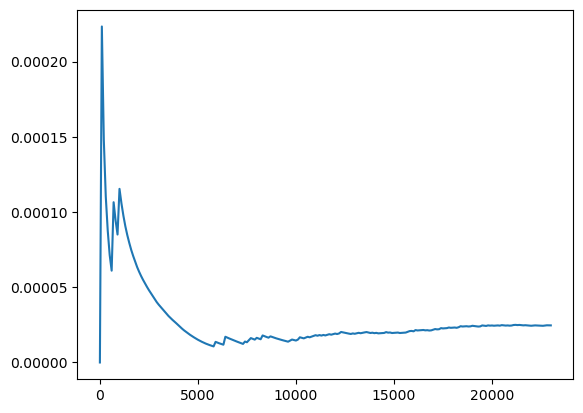

In [142]:
plt.plot(bin_edges[:-1], failure)
plt.show()